## Sentiment Classification Using Proposed CNN-GNN on IMDB binary dataset + Token Sentiment Injection

Test Results:
| metric | test 1 | test 2 | test 3 | test 4 | test 5 | Average |
|:---|:--:|:--:|:--:|:--:|:--:|:--:|
| f1-score |  |  |  |  |  |  |
| accuracy |  |  |  |  |  |  |
| precision |  |  |  |  |  |  |
| recall |  |  |  |  |  |  |
| loss |  |  |  |  |  |  |

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import BertTokenizer
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, TweetTokenizer
import time
import matplotlib.pyplot as plt
import random
from torch_scatter import scatter_max, scatter_mean, scatter_sum, scatter_std
import torchmetrics
import lightning as L
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataLoader
from copy import copy
import spacy
from umap import UMAP
from tqdm import tqdm

import os
import PyPDF2
from bs4 import BeautifulSoup
# import textract
import json
import gzip
import re
import collections
import csv
import string
import textwrap
import random
import itertools
import math

In [2]:
with open(r'data\reduced_embeddings\spacy_lg_reduced_embeddings.npy', 'rb') as f:
    embeddings = np.load(f)
nlp = spacy.load('en_core_web_lg', disable=['tok2vec','tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])
t_tokenizer = TweetTokenizer()
nlp.max_length = len(' '.join(list(nlp.vocab.strings)))+1
all_vocab_doc = nlp(' '.join(list(nlp.vocab.strings)))
all_vocab_str = [f'{t}' for t in all_vocab_doc]
embeddings = torch.from_numpy(embeddings)
embeddings = (embeddings - torch.min(embeddings)) / (torch.max(embeddings)-torch.min(embeddings))
token_vocab_dict = dict(zip(all_vocab_str, embeddings))
token_vocab_dict['<n>'] = token_vocab_dict['newline']
len(token_vocab_dict)

771064

In [3]:
with open(r'data\reduced_embeddings\spacy_polarities_subjectivities.npy', 'rb') as f:
    polarities_subjectivities= np.load(f)
polarities_subjectivities = torch.from_numpy(polarities_subjectivities)
polarity_vocab_dict = dict(zip(all_vocab_str, polarities_subjectivities))
polarity_vocab_dict['<n>'] = torch.tensor([0.0, 0.0])
len(token_vocab_dict)

771064

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 224
folder_path = r'data\TextClassification\IMDB'
device

device(type='cuda')

In [5]:
train_df = pd.read_csv(r'data\TextClassification\IMDB\test.csv')

In [6]:
train_df.head(2)

,label,text
0,1,I have seen this movie twice and it's theme is...
1,1,I happened to catch this on community TV a few...


In [7]:
keep_ratio = 1.0
test_df = pd.read_csv(r'data\TextClassification\IMDB\test.csv')
test_df['Topic'] = test_df['label']
test_df['Content'] = test_df['text']
test_df.drop(['label', 'text'], axis=1, inplace=True)
test_df.dropna(inplace=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.iloc[:int(keep_ratio*test_df.shape[0])]
train_df = pd.read_csv(r'data\TextClassification\IMDB\train.csv')
train_df['Topic'] = train_df['label']
train_df['Content'] = train_df['text']
train_df.drop(['label', 'text'], axis=1, inplace=True)
train_df.dropna(inplace=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.iloc[:int(keep_ratio*train_df.shape[0])]
sst_classes = ["Negative", "Positive"]
df = pd.concat([train_df, test_df])
df.shape

(50000, 2)

In [14]:
doc_lengths = np.array([len(tx) for tx in df['Content'].values])

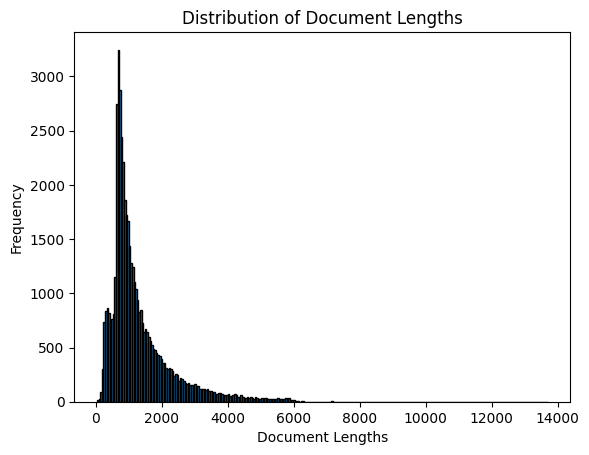

In [18]:
# Create a histogram
plt.hist(doc_lengths, bins='auto', edgecolor='black')
# plt.xlim([0,138000])
# Add labels and title
plt.xlabel('Document Lengths')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')

# Show the chart
plt.show()

In [8]:
class_list = df.Topic.unique()
class_id = {sst_classes[i]:i for i in class_list}
id_class = {i:sst_classes[i] for i in class_list}

In [9]:
char_set = set()
for doc in df.Content.values:
    char_set.update(set(' '.join(t_tokenizer.tokenize(doc))))
len(char_set)

206

In [10]:
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' '
all_chars = set(''.join(char_set).join(allowed_chars))
vocab_dict = {c:i for i, c in enumerate(all_chars)}
if '\x01' not in vocab_dict:
    vocab_dict['\x01'] = len(vocab_dict)
char_Set = set(vocab_dict.keys())
num_embedding = len(vocab_dict)

In [11]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, num_classes, char_dict, token_dict, sentiment_dict, tokenizer, shuffle=True, batch_size=128) -> None:
        super().__init__()
        # y = y[indices].values
        # y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
        
        # print(f'self.num_sections1: {len(y) // batch_size}')
        
        if len(y) % batch_size != 0:
            self.shortage = ((len(y) // batch_size)+1)*batch_size - len(y)
            empty_labels = [i%2 for i in range(self.shortage)]
            empty_strings = [id_class[l] for l in empty_labels]
            
            # print(f'y1 - {y.shape}: {y}')
            y = np.concatenate([y, empty_labels])
            # print(f'y2 - {y.shape}: {y}')
            # print(f'X1 - {X.shape}: {X}')
            X = np.concatenate([X, empty_strings])
        #     print(f'X2 - {X.shape}: {X}')
        
        # print(f'self.num_sections2: {len(y) // batch_size}')
        
        y = torch.from_numpy(y)
        self.shuffle = shuffle
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        self.X = X
        self.char_dict = char_dict
        self.char_Set = set(char_dict.keys())
        self.vocab_size = len(self.char_dict)
        self.tokenizer = tokenizer
        self.token_dict = token_dict
        self.sentiment_dict = sentiment_dict
        self.max_token_count = 0
        
        
        
        self.all_data = []
        self.token_lengths = []
        self.token_embeddign_ids = []
        
        self.sum_a = 0
        
        for doc in tqdm(self.X):
            # tokens = self.tokenizer(''.join(c for c in doc if c in self.char_Set))
            # tokens = [t.text for t in tokens]
            tokens = self.tokenizer(doc)
            if len(tokens) == 0:
                tokens = ['empty']
                            
            token_lengths = [len(t) for t in tokens]
            tokens.append('\x01')
            
            token_lengths.append(len(tokens[-1])-1)
            token_lengths = torch.from_numpy(np.array(token_lengths, dtype=np.longlong))+1
            token_embs = [self.token_dict[t] if t in self.token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
            token_sentiments = [self.sentiment_dict[t] if t in self.sentiment_dict else (0.0, 0.0) for t in tokens]
            token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
            token_sentiments = torch.from_numpy(np.array(token_sentiments, dtype=np.float32))
            doc = ' '.join(tokens)
            characters = torch.from_numpy(np.array([self.char_dict[t] for t in doc], dtype=np.longlong))
            token_positions = torch.arange(len(token_lengths), dtype=torch.long)
            token_indices = torch.repeat_interleave(token_positions, token_lengths)
            num_tokens = len(token_lengths)
            if num_tokens > self.max_token_count:
                self.max_token_count = num_tokens
            g_data = Data(x=characters,
                            token_positions=token_positions,
                            character_length = len(characters),
                            num_tokens = num_tokens,
                            token_indices=token_indices,
                            token_lengths=token_lengths,
                            token_embeddings=token_embs,
                            token_sentiments=token_sentiments)
            self.all_data.append(g_data)
        
        
        self.num_sections = len(y) // batch_size
        self.x_lengths = np.array([self.all_data[i].character_length for i in range(len(self.all_data))])
        self.x_len_args = np.argsort(self.x_lengths)[::-1]
        
        self.section_ranges = np.linspace(0, len(self.x_len_args), self.num_sections+1)
        self.section_ranges = [(int(self.section_ranges[i-1]), int(self.section_ranges[i])) for i in range(1, len(self.section_ranges))]

        self.position_j = 0
        self.section_i = 0
        self.epoch = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
        self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        
    def __getitem__(self, index):
        index = self.get_section_index()
        return self.all_data[index], self.y[index]
        
    def __len__(self):
        return len(self.y)
    
    def get_section_index(self):
        # if self.shuffle:
            
        #     t_range = self.section_ranges[self.section_i]
        #     target_index = np.random.randint(t_range[0], t_range[1])
        # else:
        #     t_range = self.section_ranges[self.section_i]
        #     target_index = t_range[0] + self.each_section_i[self.section_i]
        #     self.each_section_i[self.section_i] = (self.each_section_i[self.section_i] + 1) % (t_range[1] - t_range[0])
        # print()
        # print(f'self.section_i: {self.section_i},   self.position_j: {self.position_j}')
        target_index = self.sections[self.section_i, self.position_j]
        
        self.position_j = (self.position_j + 1) % self.section_size
        if self.position_j == 0:
            self.section_i = (self.section_i + 1) % self.num_sections
            if self.shuffle and self.section_i == 0:
                self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
                # random_positions = np.random.choice(np.arange(0, self.section_size), size=self.section_size, replace=False)
        # return self.x_len_args[target_index]
        return target_index

    def reset_params(self):
        self.section_i = 0
        self.position_j = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
    def split_into_k_groups(self, len_sorted_args, lengths:np.array, k):
        if self.shuffle and self.epoch > 0:
            randomize_sections = np.concatenate([np.random.choice(np.arange(r[0], r[1]), size=r[1]-r[0], replace=False) for r in self.section_ranges])
            len_sorted_args = len_sorted_args[randomize_sections]
        
        nums = lengths[len_sorted_args]
        groups_size = len(len_sorted_args) // k
        
        
        groups = [[] for _ in range(k)]
        group_sums = np.zeros(k, dtype=int)
        group_sizes = np.zeros(k, dtype=int)
        
        # print(f'groups_size: {groups_size}')
        # print(f'len(len_sorted_args): {len(len_sorted_args)}')
        # print(f'k: {k}')
        for i, num in enumerate(nums):
            candidate_indices = np.where(group_sizes<groups_size)[0]
            # print(f'candidate_indices: {candidate_indices}')
            min_group_idx = candidate_indices[np.argmin(group_sums[candidate_indices])]
            groups[min_group_idx].append(len_sorted_args[i])
            group_sums[min_group_idx] += num
            group_sizes[min_group_idx] += 1
        self.epoch += 1
        
        groups = np.array(groups)
        group_sums_argsort = np.argsort(group_sums)[::-1]
        groups = groups[group_sums_argsort]
        
        # check_x = self.X[groups]
        # check_x_lens = [np.sum(np.array([len(sx) for sx in rx])) for rx in check_x]
        # print(f'check_x: {check_x}')
        
        
        return np.array(groups), groups_size
        

In [12]:
from typing import List
import torch
from torch_geometric.loader import DataLoader

class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


In [13]:
def double_tokenizer(doc):
    tokens = t_tokenizer.tokenize(doc)
    tokens = nlp(' '.join(tokens))
    tokens = [t.text for t in tokens]
    return tokens

In [14]:
train_dataset = CharacterandTokenLevelCustomDataset(train_df.Content.values, train_df.Topic.values, len(class_id), vocab_dict, token_vocab_dict, polarity_vocab_dict, double_tokenizer, batch_size=batch_size)
test_dataset = CharacterandTokenLevelCustomDataset(test_df.Content.values, test_df.Topic.values, len(class_id), vocab_dict, token_vocab_dict, polarity_vocab_dict, double_tokenizer, batch_size=batch_size)
max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

100%|██████████| 25088/25088 [05:05<00:00, 82.18it/s] 


In [15]:
train_lengths = np.array([train_dataset[i][0].num_tokens for i in range(len(train_dataset))])
test_lengths = np.array([test_dataset[i][0].num_tokens for i in range(len(test_dataset))])
print(np.max(train_lengths))
print(np.max(test_lengths))

2851
2986


In [16]:
# train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
# test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=True)

In [17]:
test_dataset[0]

(Data(x=[5688], token_positions=[1185], character_length=5688, num_tokens=1185, token_indices=[5688], token_lengths=[1185], token_embeddings=[1185, 64], token_sentiments=[1185, 2]),
 tensor([0., 1.]))

In [18]:
X, y = next(iter(test_dataloader))

In [19]:
# test_dataset.reset_params()
# test_dataset.position_j = 0
# for X, y in test_dataloader:
#     print(X)

## Model Classes and Functions

In [20]:
from torch_geometric.nn import GATv2Conv, SimpleConv

class GCNN(nn.Module):
    def __init__(self, hidden_dim, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        # self.hidden_dim = hidden_dim
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4)
        # self.gnn = SimpleConv(aggr='mean')
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim//2, hidden_dim)
        # self.out_fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        # self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        # self.bn4 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x, graph, total_token_count, return_attention_weights = False):
        x1, edge_weights = self.gnn(x, graph.edge_index, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x[:total_token_count].T).T)#self.bn2(self.conv(x[:total_token_count].T).T))
        # x3 =  F.leaky_relu_(self.fc(x1[total_token_count:]))
        x3 =  F.leaky_relu_(self.bn3(self.fc(x1[total_token_count:])))
        x1 = F.leaky_relu_(self.bn1(x1[:total_token_count]))
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=0)
        # x = self.bn4(x)
        return x, edge_weights #F.leaky_relu_(self.bn4(self.out_fc(x)))

In [21]:
import networkx as nx
from torch_geometric.utils import to_networkx, to_undirected

class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_index = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_coutns )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_coutns, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_index[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_index[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
        
    def re_gen_graph(self, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
        # for i in range(base.shape[1]):
        #     edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
            
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2):
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        if v_n_e_counts>0:
            important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        else:
            important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()

        important_indices = torch.arange(total_token_coutns, dtype=torch.int64, device=x.device) + important_indices*total_token_coutns
        important_indices = important_indices.view(-1)
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_index[:, important_indices]
        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_index[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
         
    def calculate_graph(self, x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance):
        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        tc_range = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        random_ints = torch.randint(0, 2*total_token_coutns, (total_token_coutns, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = torch.arange(lattice_start_distance, self.lattice_step*lattice_edges+1, self.lattice_step, device=x.device).view(1, -1)

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = tc_range - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        # base = torch.cat([base1, base2], dim=1)
        tc_range = tc_range.view(1,-1)
        return random_links, lattice_links, tc_range
    
    def fill_lattice_and_random_edges(self, edge_index, random_links, lattice_links, tc_range):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), tc_range], dim=0)
            edge_index[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_index[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)

In [22]:

class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, pos_emb_size=8192, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.pos_emb_size = pos_emb_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        if seed>-1:
            torch.manual_seed(seed)
 
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        
        self.dropout = nn.Dropout(p=dropout)

        self.positional_encoding = nn.Embedding(pos_emb_size, embedding_dim)
        self.positional_encoding.weight = self.create_positional_encoding()

        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(2*hidden_dim + 2, hidden_dim, kernel_size=3, padding=1)
               
        self.gcnn1 = GCNN(hidden_dim)
        self.gcnn2 = GCNN(hidden_dim + inject_embedding_dim)
        self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
        k = 32
        self.fc0 =  nn.Linear(hidden_dim , hidden_dim + inject_embedding_dim)
        self.fc1 = nn.Linear(hidden_dim + inject_embedding_dim , hidden_dim * k)
        self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
        self.max_length = 0
    
    def forward(self, g_data):
        # self.max_length = max(self.max_length, len(g_data.x))
        if len(g_data.x) > self.max_length:
            self.max_length = len(g_data.x)
            print(self.max_length)
        x = self.embedding(g_data.x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, g_data.cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, g_data.cumulative_token_indices, dim=1)

        x = torch.cat([x1, x2, g_data.token_sentiments.T], dim=0)
        x = F.relu(self.conv3(x)).T
        x = x + self.positional_encoding(g_data.token_positions)

        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
            
        graph = self.graph_generator.gen_graph(x, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        rand_edges = rand_edges-1
        lattice_edges = lattice_edges-1
        
        x, edge_weights = self.gcnn1(graph.x, graph, len(g_data.token_lengths), return_attention_weights = True)
        edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
        
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
                
        x = torch.cat([x, g_data.token_embeddings], dim=1)
        x1 = F.relu(self.fc0(graph.x[g_data.token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        x, edge_weights = self.gcnn2(x, graph, len(g_data.token_lengths))

        x = F.elu_(self.fc1(x))
        doc_token_index = torch.repeat_interleave(torch.arange(len(g_data.num_tokens), device=x.device), g_data.num_tokens)
        x1 = scatter_max(x[:len(g_data.token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(g_data.token_lengths)], doc_token_index, dim=0)
        vn_embs = x[len(g_data.token_lengths):]
        x_for_cat = [x1, x2]
        x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
        x = torch.cat(x_for_cat, dim=1)
        
        x = F.elu_(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

    def create_positional_encoding(self):
        position = torch.arange(self.pos_emb_size).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * (-math.log(10000.0) / self.hidden_dim))
        pe = torch.zeros(self.pos_emb_size, self.hidden_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return torch.nn.Parameter(pe, requires_grad=False)


In [23]:
classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=64, embedding_dim=64, pos_emb_size=3072, dropout=0.2, num_out_features=len(class_id), seed=911, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2)

In [24]:
# output = classifier_torch_model(X.cpu())

In [25]:

class CnnGnnClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CnnGnnClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters(logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [26]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix


def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


## Test Model

In [27]:
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = 911

In [28]:
# Fardin Rastakhiz @ 2023
from abc import ABC, abstractmethod
from typing import List, Optional

import torch
import lightning as L
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import Logger, CSVLogger
from lightning.pytorch.tuner import Tuner
from typing import List
from pytorch_lightning.core.saving import save_hparams_to_yaml

class ModelManager(ABC):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 max_epochs = 100,
                 ckpt_path: str|None=None,
                 accumulate_grad_batches=1):
        self.torch_model = torch_model
        self.lightning_model = lightning_model
        self.log_dir = log_dir
        self.log_name = log_name
        self.model_save_dir = model_save_dir
        self.device = device
        self.accelerator = 'cpu' if self.device=='cpu' else 'gpu'
        self.max_epochs = max_epochs
        self.ckpt_path = ckpt_path

        self.logger = self._create_logger()
        self.callbacks = self._create_callbacks()
        self.trainer: L.Trainer = self._create_trainer(accumulate_grad_batches)
        self.tuner = Tuner(self.trainer)
        self.tuning_result = None

    def tune(self, data_manager=None, train_dataloaders=None, val_dataloaders=None, datamodule=None, draw_result=True, min_lr=0.0000001, max_lr=0.1):
        self.tuning_result = self.tuner.lr_find(self.lightning_model, datamodule=data_manager, train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders, min_lr=min_lr,max_lr=max_lr, num_training=150)
        if draw_result:
            fig = self.tuning_result.plot(suggest=True)
            fig.show()
        self.update_learning_rate(self.tuning_result.suggestion())
        return self.tuning_result.suggestion()
    
    def update_learning_rate(self, lr):
        self.lightning_model.update_learning_rate(lr)

    def fit(self, train_dataloaders=None, val_dataloaders=None, datamodule=None, max_epochs = -1, ckpt_path=None):
        if ckpt_path is not None and ckpt_path != '':
            self.ckpt_path = ckpt_path
        if max_epochs>0:
            self.trainer.fit_loop.max_epochs = max_epochs
            # self.max_epochs = max_epochs
            # self.trainer = self._create_trainer()
        self.trainer.fit(self.lightning_model,
                         datamodule=datamodule,
                         train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders,
                         ckpt_path = self.ckpt_path
                         )

    def validate(self, dataloaders=None, datamodule=None):
        return self.trainer.validate(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def predict(self, dataloaders=None, datamodule=None):
        return self.trainer.predict(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def _create_trainer(self, accumulate_grad_batches) -> L.Trainer:
        return L.Trainer(
            callbacks=self.callbacks,
            max_epochs=self.max_epochs,
            accelerator=self.accelerator,
            logger=self.logger,
            num_sanity_val_steps=0,
            default_root_dir=self.model_save_dir,
            accumulate_grad_batches=accumulate_grad_batches
        )

    @abstractmethod
    def _create_callbacks(self) -> List[Callback]:
        pass

    def _create_logger(self) -> Logger:
        return CSVLogger(save_dir=self.log_dir, name=self.log_name)

    @abstractmethod
    def draw_summary(self, dataloader):
        pass

    @abstractmethod
    def plot_csv_logger(self, loss_names, eval_names):
        pass
    
    def save_hyper_parameters(self):
        mhparams = {
            'start_lr': 0.045,
            'ckpt_lrs' :  {51: 0.002, 65: 0.00058},
            'last_lr' : 0.0003,
            'ac_loss_factor': 0.0002,
            'weight_decay': 0.0012
        }
        save_hparams_to_yaml(config_yaml=r'logs\hetero_model_17_AG\version_12\hparams.yaml',
                     hparams=mhparams)
        
    # def find_best_settings(data_manager,
    #                        lrs: List[float]=[0.001], dropouts: List[float]=[0.2], 
    #                        weight_decays: List[float]=[0.00055], emb_factors: List[float]=[0.1], 
    #                        batch_sizes: List[int]=[128], log_name='find_best_settings'):
    #     for lr in lrs:
    #         for dropout in dropouts:
    #             for wd in weight_decays:
    #                 for emb_factor in emb_factors:
    #                     for bs in batch_sizes:
    #                         data_manager.update_batch_size(bs)
    #                         torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 128, dropout=dropout)
    #                         lightning_model = HeteroBinaryLightningModel(torch_model,
    #                                         torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=wd),
    #                                             loss_func=HeteroLoss1(exception_keys='word', enc_factor=emb_factor),
    #                                             learning_rate=lr,
    #                                             batch_size=bs,
    #                                             user_lr_scheduler=True
    #                                             ).to(device)
    #                         model_manager = ClassifierModelManager(torch_model, lightning_model, log_name=log_name, device=device, num_train_epoch=10)
    #                         model_manager.fit(datamodule=data_manager)
    #                         model_manager.save_plot_csv_logger(name_prepend=f'{lr}_{dropout}_{wd}_{emb_factor}_{bs}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [29]:
# Fardin Rastakhiz @ 2023
import torch
# from scripts.managers.ModelManager import ModelManager
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from torch_geometric.nn import summary
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from os import path

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

import lightning as L

class ClassifierModelManager(ModelManager):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 num_train_epoch = 100,
                 accumulate_grad_batches=1):
        super(ClassifierModelManager, self).__init__(torch_model, lightning_model, model_save_dir, log_dir, log_name, device, num_train_epoch, accumulate_grad_batches=accumulate_grad_batches)

    def _create_callbacks(self) -> List[Callback]:
        return [
            ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
            # EarlyStopping(patience=50, mode='max', monitor='val_acc')
        ]

    def draw_summary(self, dataloader):
        X, y = next(iter(dataloader))
        print(summary(self.torch_model, X.to(self.device)))

    def plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        plt.show()

    def save_plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc'], name_prepend: str=""):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        
        loss_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_loss_metric.png')
        plt.savefig(loss_png)
        
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        
        acc_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_acc_metric.png')
        plt.savefig(acc_png)
        
        plt.close()
    
    def evaluate(self, eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        self.lightning_model.eval()
        for X, y in eval_dataloader:
            y_p = self.lightning_model(X.to(self.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        # if(give_hinge_loss):
        #     print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')
                
    def evaluate_best_models(self, lightning_type: L.LightningModule, eval_dataloader,
                             give_confusion_matrix: bool=True, 
                             give_report: bool=True, 
                             give_f1_score: bool=False, 
                             give_accuracy_score: bool=False, 
                             give_precision_score: bool=False, 
                             give_recall_score: bool=False, 
                             give_hinge_loss: bool=False,
                             multi_class: bool=False, **kwargs):
        self.lightning_model = lightning_type.load_from_checkpoint(rf'{self.trainer.checkpoint_callback.best_model_path}', map_location=None, hparams_file=None, strict=True, **kwargs).eval()
        self.save_evaluation(eval_dataloader, 'best_model', give_confusion_matrix, give_report,
                             give_f1_score, give_accuracy_score, give_precision_score, give_recall_score, give_hinge_loss, multi_class)
            
    def save_evaluation(self, eval_dataloader, name_prepend: str='',
                    give_confusion_matrix: bool=True, 
                    give_report: bool=True, 
                    give_f1_score: bool=False, 
                    give_accuracy_score: bool=False, 
                    give_precision_score: bool=False, 
                    give_recall_score: bool=False, 
                    give_hinge_loss: bool=False,
                    multi_class: bool=False
                    ):
            
            test_metrics_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_test_metrics.txt')
            
            y_true = []
            y_pred = []
            self.lightning_model.eval()
            self.lightning_model.model.eval()
            self.torch_model.eval()
            self.trainer.model.eval()
            for X, y in eval_dataloader:
                with torch.no_grad():
                    y_p = self.lightning_model(X.to(self.device))
                if type(y_p) is tuple:
                    y_p = y_p[0]
                
                if multi_class:
                    y_pred.append(y_p.detach().to(y.device))
                    y_true.append(y)
                else:
                    y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                    y_true.append(y.to(torch.int32))
                    
            y_true = torch.concat(y_true)
            y_pred = torch.concat(y_pred)
            print(y_true.shape)
            print(y_pred.shape)
            if multi_class:
                y_true_num = torch.argmax(y_true, dim=1)
                y_pred_num = torch.argmax(y_pred, dim=1)
            else:
                y_true_num = y_true
                y_pred_num = y_pred
                
            print(y_true_num.shape)
            print(y_pred_num.shape)
            with open(test_metrics_path, 'at+') as f:
                if(give_confusion_matrix):
                    print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
                if(give_report):
                    print(classification_report(y_true_num, y_pred_num), file=f)
                if(give_f1_score):
                    if multi_class:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
                if(give_accuracy_score):
                    print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
                if(give_precision_score):
                    if multi_class:
                        print(f'precision: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'precision: {precision_score(y_true_num, y_pred_num)}', file=f)
                if(give_recall_score):
                    if multi_class:
                        print(f'recall: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'recall: {recall_score(y_true_num, y_pred_num)}', file=f)
                # if(give_hinge_loss):
                #     print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)

In [30]:
# for i in range(10):
def train_model(epochs=30, dropout=0.2, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True):
    classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=3072, dropout=dropout, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2).to(device)
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 40, 45,50,55],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)


    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name='CNN-GNN15_imdb_sentiments',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    train_dataset.reset_params()
    train_dataset.position_j = 0
    test_dataset.reset_params()
    test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(CnnGnnClassifierLightningModel, test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

0

In [34]:
# for i in range(2):
#     time.sleep(30)
#     torch.cuda.empty_cache()
#     import gc
#     gc.collect()
#     train_model(60, 0.2, 0.000012, 0.0032, amsgrad=False, fused=True)

In [41]:
# train_model(10, 0.2, 0.000012, 0.0032, amsgrad=False, fused=True)

In [35]:
# for i in range(3):
#     train_model(60, 0.2, 0.000012, 0.0032, amsgrad=False, fused=True)

In [36]:

# for i in range(5):
#     train_model(60, 0.2, 0.000012, 0.0032, amsgrad=False, fused=True)
#     time.sleep(30)
#     torch.cuda.empty_cache()
#     import gc
#     gc.collect()
    

In [ ]:
for sp1 in [True, False]:
    for sp2 in [True, False]:
        for sp3 in [True, False]:
            for i in range(3):
                train_model(30, 0.2, 0.000012, 0.0032, amsgrad=False, fused=True, use_token_polarity=[sp1, sp2, sp3])

In [ ]:
# for i in range(2):
#     train_model(70, 0.2, 0.000012, 0.0032, amsgrad=False, fused=True)
#     time.sleep(60)
#     torch.cuda.empty_cache()
#     import gc
#     gc.collect()
#     time.sleep(60)

In [ ]:
# for i in range(5):
#     train_model(40, 0.2, 0.000012, 0.0032, amsgrad=False, fused=False)
#     time.sleep(60)
#     torch.cuda.empty_cache()
#     import gc
#     gc.collect()
#     time.sleep(60)

In [ ]:
import os
import re
from os import path
import pandas as pd

In [38]:
def get_best_results(execution_number=0, base_path='logs/CNN-GNN15_imdb_sentiments/'):
    base_path = path.join(base_path, rf'version_{execution_number}')
    best_ckpts = [f for f in os.listdir(path.join(base_path, 'checkpoints'))][:2]
    best_epochs = [int(re.search(r'\d+', ckpt).group()) for ckpt in best_ckpts ]
    
    metrics = pd.read_csv(path.join(base_path, 'metrics.csv'))

    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)
    df_metrics = pd.DataFrame(aggregation_metrics)
    
    print(f"{df_metrics['val_acc_epoch'][best_epochs]}")
    print(f"{df_metrics['val_loss_epoch'][best_epochs]}")

In [43]:
get_best_results(50, 'logs\CNN-GNN15_imdb_sentiments')

30    0.906091
54    0.905851
Name: val_acc_epoch, dtype: float64
30    0.311653
54    0.345440
Name: val_loss_epoch, dtype: float64


In [47]:
best_checkpoints = {'49': r'logs\CNN-GNN15_imdb_sentiments\version_49\checkpoints\epoch=42-step=4214.ckpt', 
          '50': r'logs\CNN-GNN15_imdb_sentiments\version_50\checkpoints\epoch=30-step=3038.ckpt',
          '59': r'logs\CNN-GNN15_imdb_sentiments\version_59\checkpoints\epoch=42-step=4816.ckptt',
          '60': r'logs\CNN-GNN15_imdb_sentiments\version_60\checkpoints\epoch=25-step=2912.ckpt',
          '61': r'logs\CNN-GNN15_imdb_sentiments\version_61\checkpoints\epoch=51-step=5824.ckpt'}

Their Result: </br>
{'losses': 0.31136547923088076, </br>
 'accuracies': 0.9054926658163265, </br>
 'precisions': 0.9056822870000001, </br>
 'recalls': 0.9054926640000002, </br>
 'f1_scores': 0.9055874557407388}

In [ ]:
get_best_results(27, 'logs/CNN-GNN14_imdb')

18    0.90504
30    0.90492
Name: val_acc_epoch, dtype: float64
18    0.252355
30    0.317930
Name: val_loss_epoch, dtype: float64


In [50]:
def get_float_numbers(line_str):
    line_str = str.split(line_str, sep=":")[-1]
    all_floats = re.findall(r"[-+]?(?:\d*\.*\d+)", line_str)
    all_floats = np.array([float(fs) for fs in all_floats])
    return all_floats

In [51]:
def get_best_results(execution_number=0, base_path='logs/CNN-GNN15_imdb_sentiments/'):
    base_path = os.path.join(base_path, rf'version_{execution_number}')
    
    best_ckpts = [f for f in os.listdir(path.join(base_path, 'checkpoints'))][:2]
    best_epochs = [int(re.search(r'\d+', ckpt).group()) for ckpt in best_ckpts ]
    
    metrics = pd.read_csv(path.join(base_path, 'metrics.csv'))

    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)
    df_metrics = pd.DataFrame(aggregation_metrics)
    
    max_acc_idx = df_metrics['val_acc_epoch'][best_epochs].argmax()
    # print(max_acc_idx)
    # print(f"{df_metrics['val_acc_epoch'][best_epochs]}")
    # print(f"{df_metrics['val_loss_epoch'][best_epochs]}")
    
    
    with open(path.join(base_path, 'best_model_test_metrics.txt'), 'rt') as f:
        all_lines = f.readlines()

    accuracy = np.mean(get_float_numbers(all_lines[13]))
    # print(f"accuracy: {accuracy}")
    precision = np.mean(get_float_numbers(all_lines[14]))
    # print(f"precision: {precision}")
    recall = np.mean(get_float_numbers(all_lines[15]))
    # print(f"recall: {recall}")
    f1_score = 2*precision*recall/(precision+recall)
    # print(f"f1_score: {f1_score}")
    loss = df_metrics['val_loss_epoch'][best_epochs[max_acc_idx]]
    # print(f"loss: {loss}")
    return loss, accuracy, precision, recall, f1_score

In [52]:
def calculate_mean(execution_numbers, base_path='logs/CNN-GNN15_imdb_sentiments/'):
    losses, accuracies, precisions, recalls, f1_scores = [], [], [], [], []
    for i in execution_numbers:
        loss, accuracy, precision, recall, f1_score = get_best_results(i, base_path)
        losses.append(loss)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
    losses, accuracies, precisions, recalls, f1_scores = np.mean(losses),  np.mean(accuracies),  np.mean(precisions),  np.mean(recalls),  np.mean(f1_scores)
    return {'losses': losses, 'accuracies':accuracies, 'precisions':precisions, 'recalls':recalls, 'f1_scores':f1_scores}

In [53]:
calculate_mean([49, 50, 59, 60, 61], base_path='logs/CNN-GNN15_imdb_sentiments/')

{'losses': 0.31136547923088076,
 'accuracies': 0.9054926658163265,
 'precisions': 0.9056822870000001,
 'recalls': 0.9054926640000002,
 'f1_scores': 0.9055874557407388}

In [ ]:
if True:
    si_all = {'0': r'logs\CNN-GNN15_imdb_sentiments\version_0\checkpoints\epoch=15-step=3136.ckpt', 
            #'0': r'logs\CNN-GNN15_imdb_sentiments\version_0\checkpoints\epoch=23-step=4704.ckpt',
            '1': r'logs\CNN-GNN15_imdb_sentiments\version_1\checkpoints\epoch=20-step=4116.ckpt',
            '2': r'logs\CNN-GNN15_imdb_sentiments\version_2\checkpoints\epoch=16-step=3332.ckpt'}

    si_p1_p2 = {'3': r'logs\CNN-GNN15_imdb_sentiments\version_3\checkpoints\epoch=15-step=3136.ckpt',
                # '4': r'logs\CNN-GNN15_imdb_sentiments\version_4\checkpoints\epoch=25-step=5096.ckpt',
                '4': r'logs\CNN-GNN15_imdb_sentiments\version_4\checkpoints\epoch=27-step=5488.ckpt',
                '5': r'logs\CNN-GNN15_imdb_sentiments\version_5\checkpoints\epoch=27-step=5488.ckpt',
                # '5': r'logs\CNN-GNN15_imdb_sentiments\version_5\checkpoints\epoch=18-step=3724.ckpt'
                }

    si_p1_p3 = {'6': r'logs\CNN-GNN15_imdb_sentiments\version_6\checkpoints\epoch=25-step=5096.ckpt',
                '7': r'logs\CNN-GNN15_imdb_sentiments\version_7\checkpoints\epoch=28-step=5684.ckpt',
                '8': r'logs\CNN-GNN15_imdb_sentiments\version_8\checkpoints\epoch=20-step=4116.ckpt',
                '8': r'logs\CNN-GNN15_imdb_sentiments\version_8\checkpoints\epoch=22-step=4508.ckpt'
                }

    si_p1 = {'9': r'logs\CNN-GNN15_imdb_sentiments\version_9\checkpoints\epoch=25-step=5096.ckpt',
            '10': r'logs\CNN-GNN15_imdb_sentiments\version_10\checkpoints\epoch=15-step=3136.ckpt',
            '11': r'logs\CNN-GNN15_imdb_sentiments\version_11\checkpoints\epoch=21-step=4312.ckpt'}

    si_p2_p3 = {'12': r'logs\CNN-GNN15_imdb_sentiments\version_12\checkpoints\epoch=27-step=5488.ckpt',
                '13': r'logs\CNN-GNN15_imdb_sentiments\version_13\checkpoints\epoch=27-step=5488.ckpt',
                '14': r'logs\CNN-GNN15_imdb_sentiments\version_14\checkpoints\epoch=20-step=4116.ckpt'}

    si_p2 = {'15': r'logs\CNN-GNN15_imdb_sentiments\version_15\checkpoints\epoch=21-step=4312.ckpt',
            '16': r'logs\CNN-GNN15_imdb_sentiments\version_16\checkpoints\epoch=21-step=4312.ckpt',
            '17': r'logs\CNN-GNN15_imdb_sentiments\version_17\checkpoints\epoch=19-step=3920.ckpt'}

    si_p3 = {'18': r'logs\CNN-GNN15_imdb_sentiments\version_18\checkpoints\epoch=14-step=2940.ckpt',
            '19': r'logs\CNN-GNN15_imdb_sentiments\version_19\checkpoints\epoch=16-step=3332.ckpt',
            '20': r'logs\CNN-GNN15_imdb_sentiments\version_20\checkpoints\epoch=15-step=3136.ckpt'}

    si_none = {'24': r'logs\CNN-GNN15_imdb_sentiments\version_24\checkpoints\epoch=24-step=4900.ckpt',
           '25': r'logs\CNN-GNN15_imdb_sentiments\version_25\checkpoints\epoch=20-step=4116.ckpt',
           '26': r'logs\CNN-GNN15_imdb_sentiments\version_26\checkpoints\epoch=25-step=5096.ckpt'}

In [ ]:
si_types = {'si_all': [True, True, True], 'si_p1_p2':[True, True, False], 'si_p1_p3':[True, False, True], 'si_p1':[True, False, False], 'si_p2_p3':[False, True, True], 'si_p2':[False, True, False], 'si_p3':[False, False, True], 'si_none':[False, False, False]}

In [ ]:
classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=3072, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_token_polarity=si_types['si_all'])
classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(si_all['2'], model=classifier_torch_model, num_classes=len(class_id)).eval()

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


In [ ]:
checkpt = torch.load(si_all['2'], map_location=lambda storage, loc: storage)
model_state_dict = classifier_torch_model.state_dict()
for k in checkpt['state_dict']:
    if k[6:] in model_state_dict:
        model_state_dict[k[6:]] = checkpt['state_dict'][k]
    else:
        print(f"Error: it doesn't have the key: {k[6:]}")
classifier_torch_model.load_state_dict(model_state_dict)
classifier_torch_model.eval()

In [ ]:
lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(r"logs\CNN-GNN15_imdb_sentiments\version_0\checkpoints\epoch=15-step=3136.ckpt", map_location=None, hparams_file=None, strict=True, model=classifier_torch_model, num_classes=len(class_id)).eval()

In [ ]:
if True:
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []
    seed=911

    for k in si_all:    
        classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=3072, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_token_polarity=si_types['si_all'])
        
        checkpt = torch.load(si_all[k], map_location=lambda storage, loc: storage)
        model_state_dict = classifier_torch_model.state_dict()
        for k in checkpt['state_dict']:
            if k[6:] in model_state_dict:
                model_state_dict[k[6:]] = checkpt['state_dict'][k]
            else:
                print(f"Error: it doesn't have the key: {k[6:]}")
        classifier_torch_model.load_state_dict(model_state_dict)
        classifier_torch_model.to(device)
        classifier_torch_model.eval()
        
        # classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(si_all[k], map_location=None, hparams_file=None, strict=True, model=classifier_torch_model, num_classes=len(class_id)).eval()
        mean_infer_acc = []
        mean_infer_f1 = []
        mean_infer_prec = []
        mean_infer_rec = []
        for i in range(5):
            all_ys = []
            all_y_preds = []
            for X, y in test_dataloader:
                with torch.no_grad():
                    y_pred = classifier_torch_model(X.to(device))
                all_ys.append(torch.argmax(y,dim=1))
                all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
            all_ys = torch.concat(all_ys)
            all_y_preds = torch.concat(all_y_preds)
            
            cm = confusion_matrix(all_ys, all_y_preds)
            
            accuracy = np.sum(np.diag(cm))/ np.sum(cm)
            precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
            recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
            f1_score = (2*precision*recall)/(precision + recall)
            
            mean_infer_acc.append(accuracy)
            mean_infer_f1.append(f1_score)
            mean_infer_prec.append(precision)
            mean_infer_rec.append(recall)
        mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
        mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
        mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
        mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
        
        print(f'accuracy {k}: {mean_infer_acc}')
        print(f'f1 {k}: {mean_infer_f1}')
        print(f'prec {k}: {mean_infer_prec}')
        print(f'rec {k}: {mean_infer_rec}')
        total_accuracy.append(mean_infer_acc)
        total_f1.append(mean_infer_f1)
        total_prec.append(mean_infer_prec)
        total_rec.append(mean_infer_rec)

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')

In [ ]:
best_checkpoints = {'0': r'logs\CNN-GNN14_imdb\version_0\checkpoints\epoch=21-step=4312.ckpt',
                    '1': r'logs\CNN-GNN14_imdb\version_1\checkpoints\epoch=16-step=3332.ckpt',
                    '2': r'logs\CNN-GNN14_imdb\version_2\checkpoints\epoch=15-step=3136.ckpt',
                    '3': r'logs\CNN-GNN14_imdb\version_3\checkpoints\epoch=21-step=4312.ckpt',
                    '4': r'logs\CNN-GNN14_imdb\version_4\checkpoints\epoch=21-step=4312.ckpt'}

In [48]:
if True:
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []


    for k in best_checkpoints:
        classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=3072, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2)
        classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(best_checkpoints[k], model=classifier_torch_model, num_classes=len(class_id)).eval()
        mean_infer_acc = []
        mean_infer_f1 = []
        mean_infer_prec = []
        mean_infer_rec = []
        for i in range(5):
            all_ys = []
            all_y_preds = []
            for X, y in test_dataloader:
                with torch.no_grad():
                    y_pred = classfier_lightning_model(X.to(device))
                all_ys.append(torch.argmax(y,dim=1))
                all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
            all_ys = torch.concat(all_ys)
            all_y_preds = torch.concat(all_y_preds)
            
            cm = confusion_matrix(all_ys, all_y_preds)
            
            accuracy = np.sum(np.diag(cm))/ np.sum(cm)
            precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
            recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
            f1_score = (2*precision*recall)/(precision + recall)
            
            mean_infer_acc.append(accuracy)
            mean_infer_f1.append(f1_score)
            mean_infer_prec.append(precision)
            mean_infer_rec.append(recall)
        mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
        mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
        mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
        mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
        
        print(f'accuracy {k}: {mean_infer_acc}')
        print(f'f1 {k}: {mean_infer_f1}')
        print(f'prec {k}: {mean_infer_prec}')
        print(f'rec {k}: {mean_infer_rec}')
        total_accuracy.append(mean_infer_acc)
        total_f1.append(mean_infer_f1)
        total_prec.append(mean_infer_prec)
        total_rec.append(mean_infer_rec)

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


301590
301592


C:\Users\fardin\AppData\Local\Temp\ipykernel_1844\2901102002.py:29: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))


301723


C:\Users\fardin\AppData\Local\Temp\ipykernel_1844\2901102002.py:29: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))


accuracy 49: 0.5000239158163265
f1 49: nan
prec 49: nan
rec 49: 0.5000239158163265


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


301571


KeyboardInterrupt: 

In [ ]:
# CNN-GNN14_imdb
# fused on:
best_checkpoints_fused_on = {'18': r'logs\CNN-GNN14_imdb\version_18\checkpoints\epoch=23-step=4704.ckpt',
                             '19': r'logs\CNN-GNN14_imdb\version_19\checkpoints\epoch=21-step=4312.ckpt',
                             '20': r'logs\CNN-GNN14_imdb\version_20\checkpoints\epoch=30-step=6076.ckpt',
                             '21': r'logs\CNN-GNN14_imdb\version_21\checkpoints\epoch=21-step=4312.ckpt',
                             '22': r'logs\CNN-GNN14_imdb\version_22\checkpoints\epoch=25-step=5096.ckpt',
                             }

# fused on:
best_checkpoints_fused_off = {'23': r'logs\CNN-GNN14_imdb\version_23\checkpoints\epoch=21-step=4312.ckpt',
                              '24': r'logs\CNN-GNN14_imdb\version_24\checkpoints\epoch=34-step=6860.ckpt',
                              '25': r'logs\CNN-GNN14_imdb\version_25\checkpoints\epoch=34-step=6860.ckpt',
                              '26': r'logs\CNN-GNN14_imdb\version_26\checkpoints\epoch=32-step=6468.ckpt',
                              '27': r'logs\CNN-GNN14_imdb\version_27\checkpoints\epoch=18-step=3724.ckpt'}

In [ ]:
calculate_mean([23, 24, 25, 26, 27], 'logs/CNN-GNN14_imdb')

{'losses': 0.2982066869735718,
 'accuracies': 0.903208,
 'precisions': 0.9034025120000001,
 'recalls': 0.903208,
 'f1_scores': 0.9033052366785561}

In [ ]:
calculate_mean([18, 19, 20, 21, 22], 'logs/CNN-GNN14_imdb')

{'losses': 0.3015179574489594,
 'accuracies': 0.9037200000000001,
 'precisions': 0.9037939429999999,
 'recalls': 0.9037200000000001,
 'f1_scores': 0.9037569696843178}

In [ ]:
if True:
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []

    for k in best_checkpoints_fused_on:
        classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=3072, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2)
        
        checkpt = torch.load(best_checkpoints_fused_on[k], map_location=lambda storage, loc: storage)
        model_state_dict = classifier_torch_model.state_dict()
        for k in checkpt['state_dict']:
            if k[6:] in model_state_dict:
                model_state_dict[k[6:]] = checkpt['state_dict'][k]
            else:
                print(f"Error: it doesn't have the key: {k[6:]}")
        classifier_torch_model.load_state_dict(model_state_dict)
        classifier_torch_model.to(device)
        classifier_torch_model.eval()
        
        
        # classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=8192, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2)
        # classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(best_checkpoints_fused_on[k], model=classifier_torch_model, num_classes=len(class_id)).eval()
        mean_infer_acc = []
        mean_infer_f1 = []
        mean_infer_prec = []
        mean_infer_rec = []
        for i in range(5):
            all_ys = []
            all_y_preds = []
            for X, y in test_dataloader:
                with torch.no_grad():
                    y_pred = classfier_lightning_model(X.to(device))
                all_ys.append(torch.argmax(y,dim=1))
                all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
            all_ys = torch.concat(all_ys)
            all_y_preds = torch.concat(all_y_preds)
            
            cm = confusion_matrix(all_ys, all_y_preds)
            
            accuracy = np.sum(np.diag(cm))/ np.sum(cm)
            precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
            recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
            f1_score = (2*precision*recall)/(precision + recall)
            
            mean_infer_acc.append(accuracy)
            mean_infer_f1.append(f1_score)
            mean_infer_prec.append(precision)
            mean_infer_rec.append(recall)
        mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
        mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
        mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
        mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
        
        print(f'accuracy {k}: {mean_infer_acc}')
        print(f'f1 {k}: {mean_infer_f1}')
        print(f'prec {k}: {mean_infer_prec}')
        print(f'rec {k}: {mean_infer_rec}')
        total_accuracy.append(mean_infer_acc)
        total_f1.append(mean_infer_f1)
        total_prec.append(mean_infer_prec)
        total_rec.append(mean_infer_rec)

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')

RuntimeError: Error(s) in loading state_dict for CNN_for_Text:
	size mismatch for embedding.weight: copying a param with shape torch.Size([96, 64]) from checkpoint, the shape in current model is torch.Size([207, 64]).
	size mismatch for conv3.weight: copying a param with shape torch.Size([64, 130, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3]).
	size mismatch for conv5_sentiment.weight: copying a param with shape torch.Size([64, 64, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3]).

In [ ]:
best_checkpoint = r'logs\CNN-GNN14_imdb\version_35\checkpoints\epoch=29-step=5880.ckpt'
classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=3072, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2)
classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(best_checkpoint, model=classifier_torch_model, num_classes=len(class_id)).eval()

In [ ]:
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

In [ ]:
all_ys = []
all_y_preds = []

for X, y in test_dataloader:
    with torch.no_grad():
        y_pred = classfier_lightning_model(X.to(device))
    all_ys.append(torch.argmax(y,dim=1))
    all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
all_ys = torch.concat(all_ys)
all_y_preds = torch.concat(all_y_preds)

In [ ]:
wrong_answers = torch.where(all_ys!=all_y_preds)[0]

In [ ]:
id_class

{0: 'Negative', 1: 'Positive'}

In [ ]:
polarity_vocab_dict['monument']

tensor([0., 0.])

In [ ]:
target = wrong_answers[10]
print(f'original: {id_class[all_ys[target].item()]}')
print(f'predict:  {id_class[all_y_preds[target].item()]}')
print(test_df.Content.values[target])

original: Negative
predict:  Positive
Great music, but ain't these people PATHETIC?!? A true period piece of The Trippy Sixties, and it left me depressed. The director paints the wrong side of the jetset life and it stings as a hornets nest. If the culture of the time led people to do these things, it appears to me that it was all a journey of no discovery, only despair. I tried, really tried, to like this film, but these people aren't anywhere on my page. Yes, it would be nice to see the world, go away for awhile, but I always plan to come BACK. Drugs aren't the cause of these characters' downfalls, it's their lousy attitudes  these guys passionately drink their cup of poison. They cheapen their lives, and in the end, cheapen the journey that is life. Has romance ever been so dark?<br /><br />Cheers: Interesting scenery. Wonderful soundtrack by Pink Floyd.<br /><br />Caveats: Dated. Drugs. Depressing. Thoroughly unlikable characters; they aren't flower children.<br /><br />Only for t

In [ ]:
model="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
bert_tokenizer = BertTokenizer.from_pretrained(model)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
# t_tokenizer.tokenize(test_df.Content.values[target])

In [ ]:
# bert_tokenizer.tokenize(test_df.Content.values[target])

In [ ]:
# [t for t in nlp(test_df.Content.values[target])]

In [ ]:
test_dataset[wrong_answers[0]]

(Data(x=[1638], token_positions=[324], character_length=1638, num_tokens=324, token_indices=[1638], token_lengths=[324], token_embeddings=[324, 64], token_sentiments=[324, 2]),
 tensor([0., 1.]))

In [ ]:
# token_vocab_dict['Rating']

tensor([0.5690, 0.4279, 0.4346, 0.4461, 0.3818, 0.4812, 0.4366, 0.4414, 0.4344,
        0.4238, 0.4482, 0.4549, 0.4248, 0.4391, 0.4586, 0.4327, 0.4505, 0.4512,
        0.4434, 0.4419, 0.4308, 0.4346, 0.4399, 0.4611, 0.4297, 0.4528, 0.4385,
        0.4429, 0.4572, 0.4548, 0.4501, 0.4404, 0.4428, 0.4398, 0.4401, 0.4505,
        0.4367, 0.4604, 0.4323, 0.4415, 0.4319, 0.4389, 0.4170, 0.4280, 0.4440,
        0.4366, 0.4440, 0.4463, 0.4444, 0.4423, 0.4420, 0.4493, 0.4414, 0.4523,
        0.4494, 0.4485, 0.4456, 0.4471, 0.4572, 0.3837, 0.4540, 0.4410, 0.4355,
        0.4449])

In [ ]:
wrong_answers.shape

torch.Size([2380])

In [ ]:
from torch.utils.flop_counter import FlopCounterMode

In [ ]:
classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=3072, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_token_polarity=[True, False, True]).to(device)
classifier_torch_model.eval()
flopt_counter = FlopCounterMode(classifier_torch_model)
with flopt_counter:
    classifier_torch_model(X.to(device))

Module                          FLOP    % Total
------------------------  ----------  ---------
CNN_for_Text              45366.445M    100.00%
 - aten.convolution       21007.046M     46.31%
 - aten.addmm             24359.399M     53.69%
 CNN_for_Text.conv1        8175.821M     18.02%
  - aten.convolution       8175.821M     18.02%
 CNN_for_Text.conv2        8175.821M     18.02%
  - aten.convolution       8175.821M     18.02%
 CNN_for_Text.conv3        2086.906M      4.60%
  - aten.convolution       2086.906M      4.60%
 CNN_for_Text.gcnn1         856.166M      1.89%
  - aten.addmm              342.467M      0.75%
  - aten.convolution        513.700M      1.13%
 CNN_for_Text.sentiment2    695.635M      1.53%
  - aten.addmm              695.635M      1.53%
 CNN_for_Text.fc0             0.000M      0.00%
  - aten.addmm                0.000M      0.00%
 CNN_for_Text.gcnn2        3424.666M      7.55%
  - aten.addmm             1369.866M      3.02%
  - aten.convolution       2054.799M    